In [1]:
#load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#load dataset
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [6]:
#convert data into time series
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

data = pd.read_csv('AirPassengers.csv', parse_dates = ['Month'], index_col='Month', date_parser=dateparse)

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


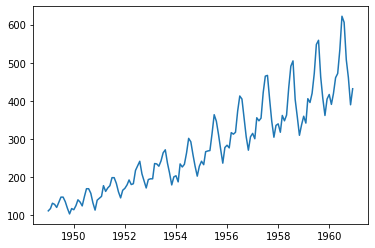

In [7]:
#let's check stationarity of time series
plt.plot(data)
#we can observe overall increasing trend in data

In [0]:
#check stationarity of TS using Dickey-Fuller test
def test_stationarity(ts):
  #determine rolling statistics
  rolmean = ts.rolling(12).mean()
  rolstd = ts.rolling(12).std()

  #plot rolling statistics
  org = plt.plot(ts, color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling mean')
  std = plt.plot(rolstd, color='black', label='Rolling std')

  plt.legend(loc='best')
  plt.title('Rolling statistics')
  plt.show(block=False)

  print("Results:")
  temp_data = ts.iloc[:,0].values
  test = adfuller(temp_data, autolag='AIC')
  output =  pd.Series(test[0:4], index= ['Test statistics','p-value','lags used','no of observations'])
  for key,value in test[4].items():
    output['critical value%s'%key] = value
  print(output)


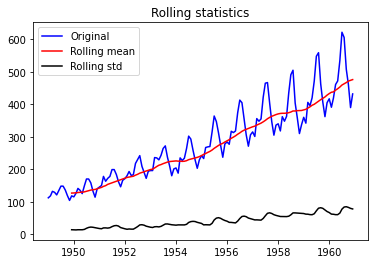

Results:
Test statistics         0.815369
p-value                 0.991880
lags used              13.000000
no of observations    130.000000
critical value1%       -3.481682
critical value5%       -2.884042
critical value10%      -2.578770
dtype: float64


In [9]:
test_stationarity(data)
#variation in std is small
#mean is increasing over time
#test statistics is way more than critical values
#hence it is not stationary

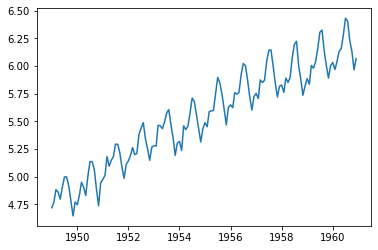

In [10]:
#eliminate trend
#log transfrom

log_data = np.log(data)
plt.plot(log_data)

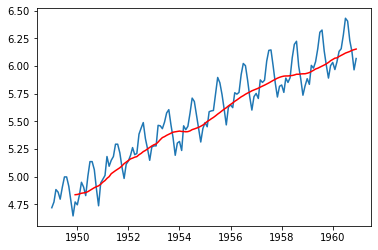

In [11]:
#We'll use Smoothing method to remove trend from TS
#take average on frequency of time (i.e. over past year-12 months)

moving_avg = log_data.rolling(12).mean()
plt.plot(log_data)
plt.plot(moving_avg, color='red')

In [12]:
#subtract rolling mean from original series
log_moving_mean_diff = log_data - moving_avg
log_moving_mean_diff.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


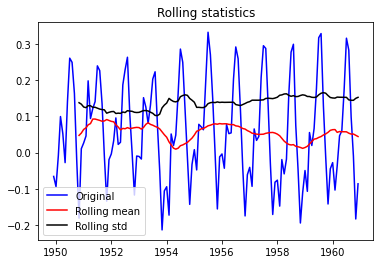

Results:
Test statistics        -3.162908
p-value                 0.022235
lags used              13.000000
no of observations    119.000000
critical value1%       -3.486535
critical value5%       -2.886151
critical value10%      -2.579896
dtype: float64


In [15]:
#lets drop NaN values
log_moving_mean_diff.dropna(inplace=True)
test_stationarity(log_moving_mean_diff)
#observation: difference between test statistics and critical values is less

ERROR! Session/line number was not unique in database. History logging moved to new session 59


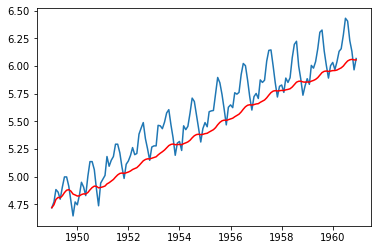

In [17]:
# exponentially weighted moving average: where more weight is given to more recent values
exp_weight_avg = log_data.ewm(halflife=12).mean()
plt.plot(log_data)
plt.plot(exp_weight_avg, color='red')


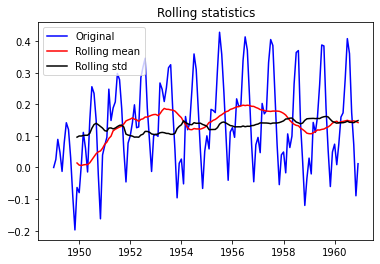

Results:
Test statistics        -3.601262
p-value                 0.005737
lags used              13.000000
no of observations    130.000000
critical value1%       -3.481682
critical value5%       -2.884042
critical value10%      -2.578770
dtype: float64


In [18]:
log_ewm_diff = log_data - exp_weight_avg
test_stationarity(log_ewm_diff)
#here test statistics is smaller than critical value, which is better

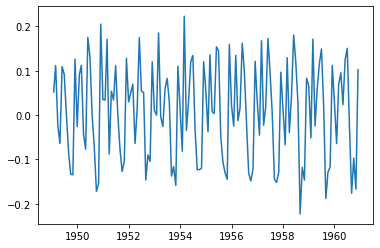

In [19]:
#eliminating trend and seasonality
#method 1: Differencing:
log_diff = log_data - log_data.shift()
plt.plot(log_diff)

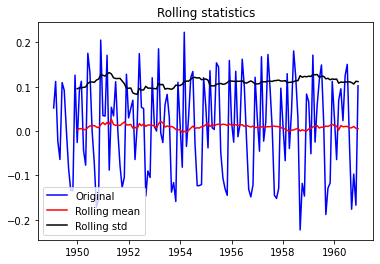

Results:
Test statistics        -2.717131
p-value                 0.071121
lags used              14.000000
no of observations    128.000000
critical value1%       -3.482501
critical value5%       -2.884398
critical value10%      -2.578960
dtype: float64


In [20]:
log_diff.dropna(inplace=True)
test_stationarity(log_diff)

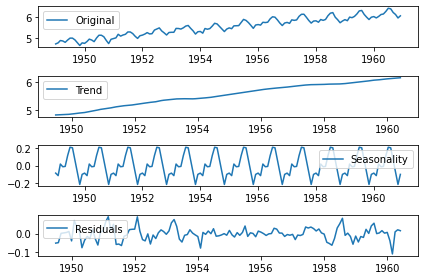

In [22]:
#method 2: decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_data)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(log_data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

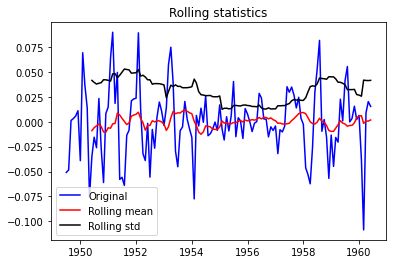

Results:
Test statistics      -6.332387e+00
p-value               2.885059e-08
lags used             9.000000e+00
no of observations    1.220000e+02
critical value1%     -3.485122e+00
critical value5%     -2.885538e+00
critical value10%    -2.579569e+00
dtype: float64


In [23]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)
#test statistics is much lower than critical value, hence it is very close to stationary.